In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
from neuralprophet import NeuralProphet, save, load
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


# Load timeseries data

In [2]:
# load water data
water_data = pd.read_csv("water_consumption_data/water.csv")

# Set date as index
water_data["Datetime"] = pd.to_datetime(water_data["Datetime"])
water_data = water_data.set_index("Datetime")

water_data

,Consumption
Datetime,
2002-01-01 01:00:00,30393
2002-01-01 02:00:00,29265
2002-01-01 03:00:00,28357
2002-01-01 04:00:00,27899
2002-01-01 05:00:00,28057
...,...
2016-12-31 19:00:00,34478
2016-12-31 20:00:00,33328
2016-12-31 21:00:00,32197


In [3]:
# Check for missing and duplicate values
print(f"missing date values: {water_data.index.isnull().any() == True}")
print(f"missing water consumption values: {water_data['Consumption'].isnull().any() == True}")
print(f"Duplicate date values: {water_data.index.has_duplicates}" )

missing date values: False
missing water consumption values: False
Duplicate date values: True


In [4]:
# Show duplicate values
water_data[water_data.index.duplicated()]

,Consumption
Datetime,
2014-11-02 02:00:00,23755
2015-11-01 02:00:00,21171
2016-11-06 02:00:00,21692


In [5]:
# Remove duplicates (keep the first occurencies)
water_data = water_data[~water_data.index.duplicated()]
water_data

,Consumption
Datetime,
2002-01-01 01:00:00,30393
2002-01-01 02:00:00,29265
2002-01-01 03:00:00,28357
2002-01-01 04:00:00,27899
2002-01-01 05:00:00,28057
...,...
2016-12-31 19:00:00,34478
2016-12-31 20:00:00,33328
2016-12-31 21:00:00,32197


In [6]:
# Sort by date in case order changed
water_data = water_data.sort_index()

# Plot timeseries

We plot the timeseries on hourly, daily, and weekly frequency. The last two aggreagate the values of every 24 and 168 hours respectively

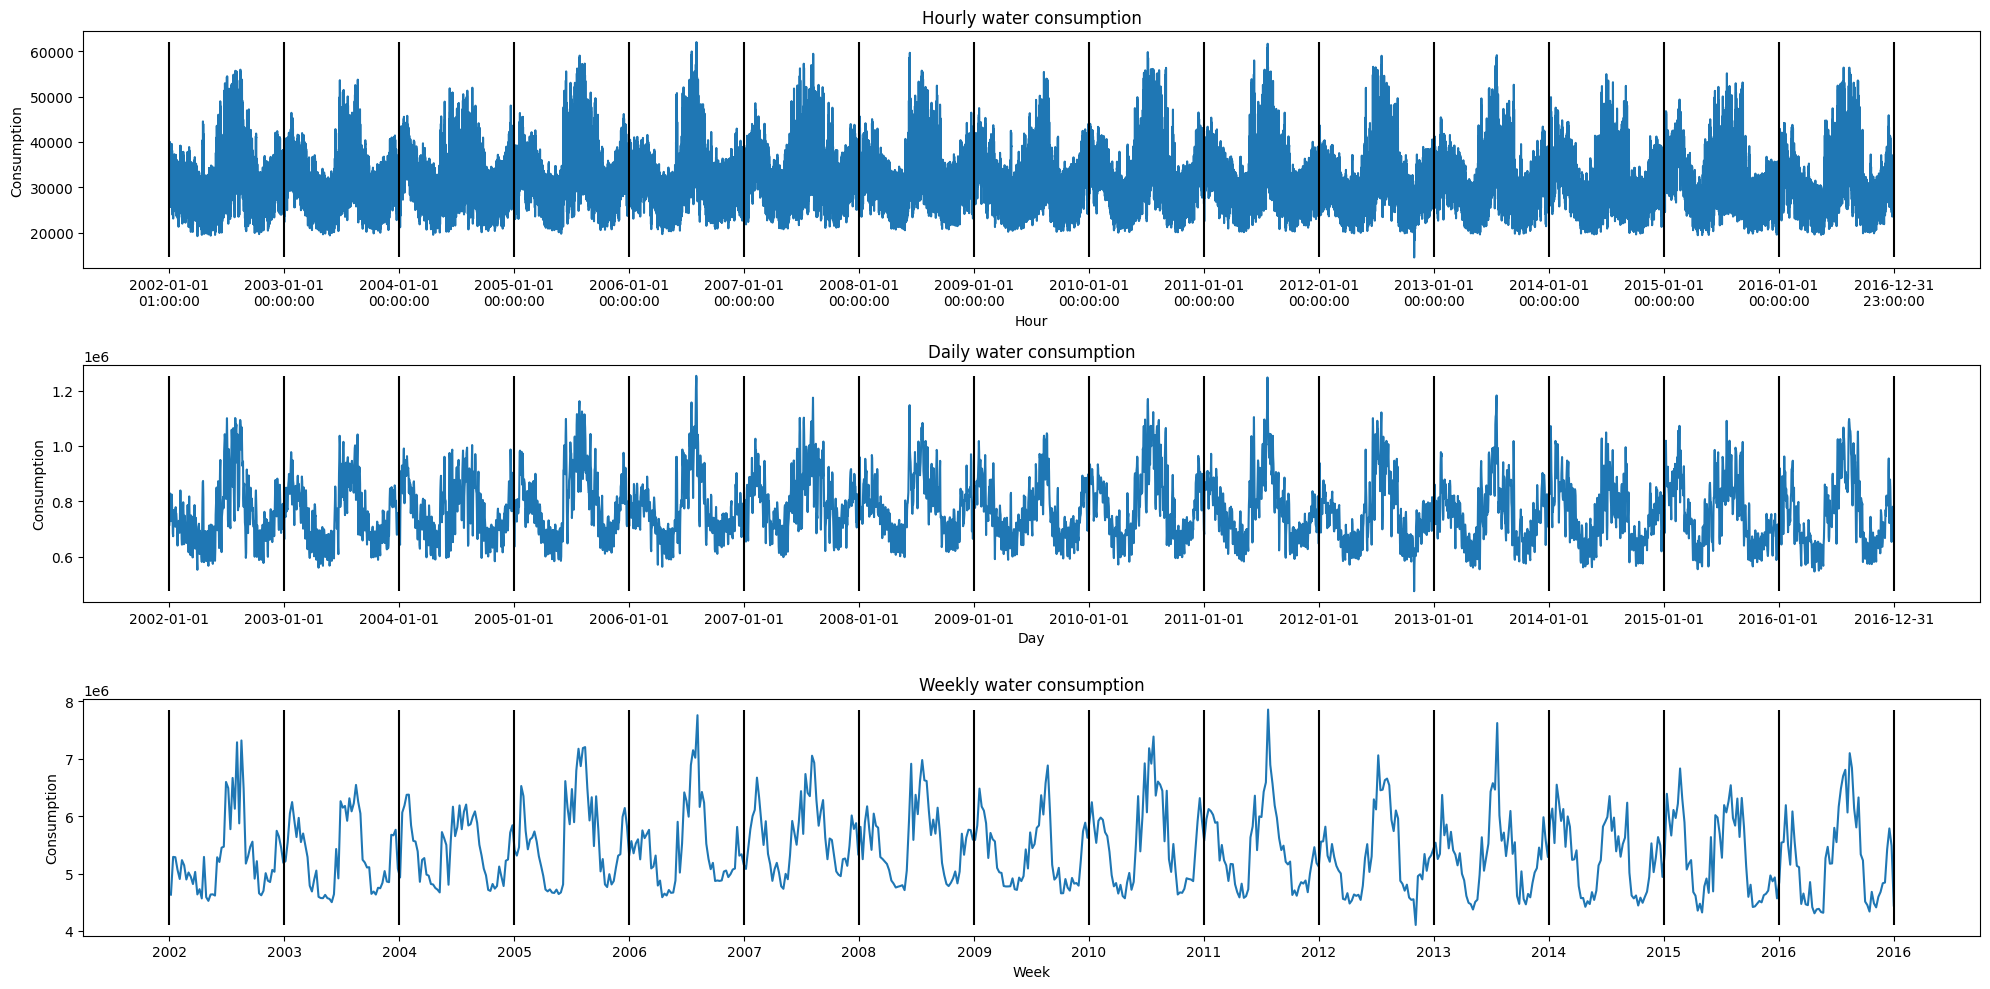

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

# HOURLY

# Get the dates
dates = water_data.index

# Plot only the first labels of each year
xticks1 = [dates[0]] + dates[(dates.hour == 0) & (dates.day == 1) & (dates.month == 1)].tolist() + [dates[-1]]

axes[0].plot(water_data)
axes[0].set_xlabel("Hour")
axes[0].set_xticks(xticks1, [str(tick).split(" ")[0] + "\n"+str(tick).split(" ")[1] for tick in xticks1])

# Add vertical lines to each year
axes[0].vlines(xticks1, ymin=water_data.min(), ymax=water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[0].set_ylabel("Consumption")
axes[0].set_title("Hourly water consumption")

# DAILY

daily_water_data = water_data.resample('D').sum()

axes[1].plot(daily_water_data)
axes[1].set_xlabel("Day")
axes[1].set_xticks(xticks1)

# Add vertical lines to each year
axes[1].vlines(xticks1, ymin=daily_water_data.min(), ymax=daily_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[1].set_ylabel("Consumption")
axes[1].set_title("Daily water consumption")

# WEEKLY

weekly_water_data = water_data.resample('W').sum()

axes[2].plot(weekly_water_data)
axes[2].set_xlabel("Week")
axes[2].set_xticks(xticks1, [str(tick).split("-")[0] for tick in xticks1])

# Add vertical lines to each year
axes[2].vlines(xticks1, ymin=weekly_water_data.min(), ymax=weekly_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[2].set_ylabel("Consumption")
axes[2].set_title("Weekly water consumption")

plt.tight_layout()
plt.show()

# Analize timeseries

## First plots

From a first point of view, we can suppose that the timeseries is stationary with a yearly seasonality component. Lets take a look closer, in an interval of one year, month and week:

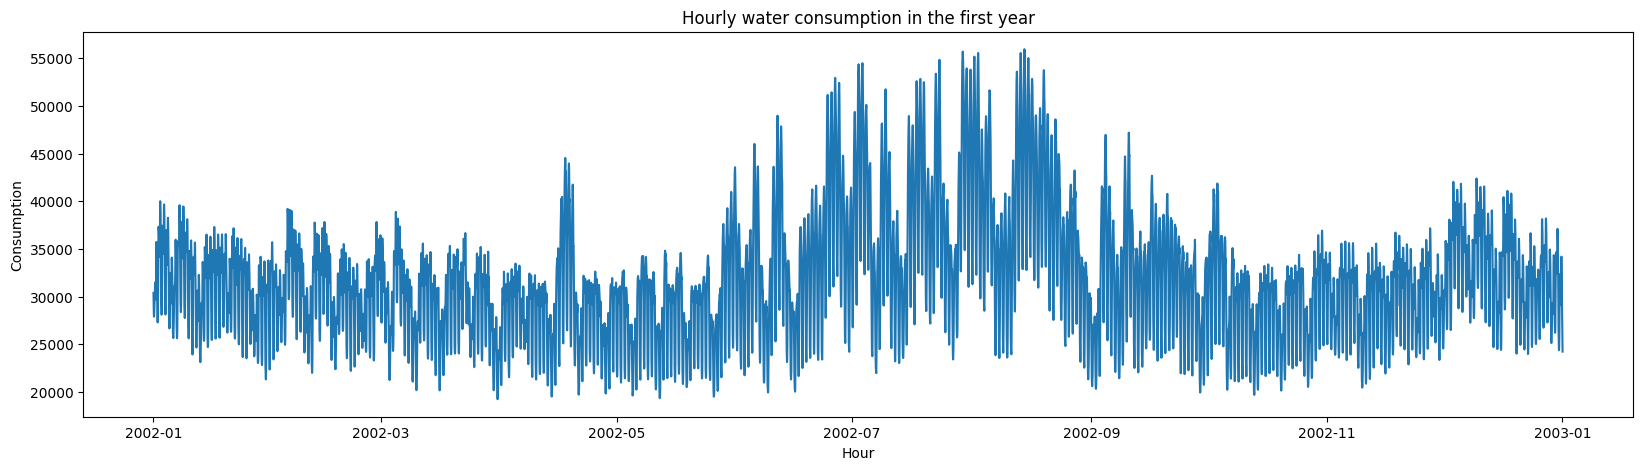

In [12]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*365))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first year")
plt.show()

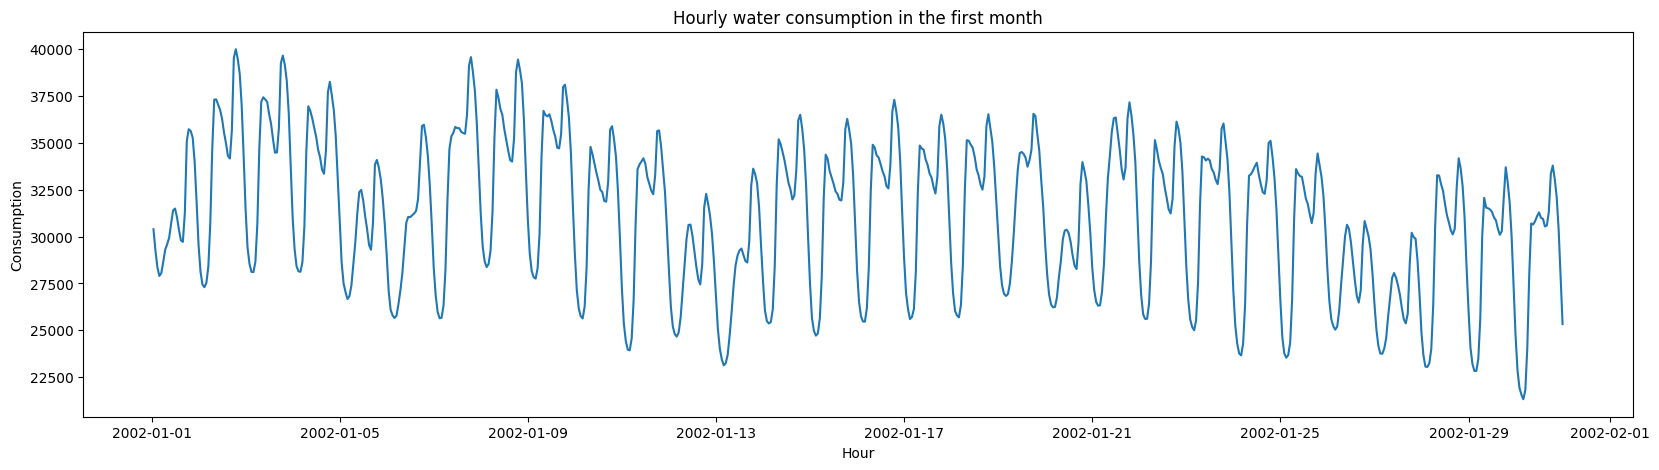

In [13]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*30))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first month")
plt.show()

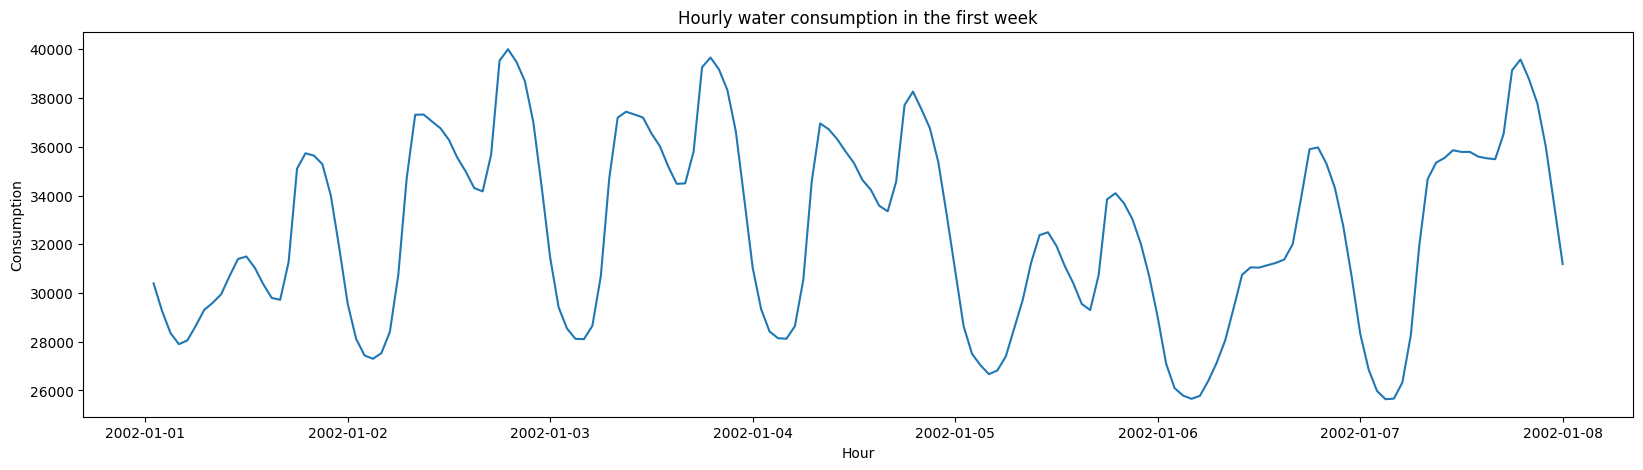

In [14]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*7))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first week")
plt.show()

It seems that it is likely for the timeseries to have a weekly and daily seasonality as well.

## Stationarity test

Lets first test for the **stationarity** of the timeseries. We use a statistical test which is called **Augmented Dickey-Fuller Test**. It uses the following **null** and **alternative** hypothesis:

H0: The time series is non-stationary.<br>
HA: The time series is stationary.

In [15]:
# Perform augmented Dickey-Fuller test
adfuller(water_data["Consumption"])

(-17.99813798235567,
 2.7400016428095592e-30,
 73,
 131393,
 {'1%': -3.43039976998591,
  '5%': -2.861561997611945,
  '10%': -2.566781708548999},
 1894827.9045179007)

The **p-value** is approximately **2.74*10^(-30)**, which means it is less than any common used significance level (for example 0.05). We conclude that we can reject the null hypothesis and consider our timeseries stationary

## Seasonality test

Lets make a periodogram to observe any periodicity (seasonality) in the timeseries

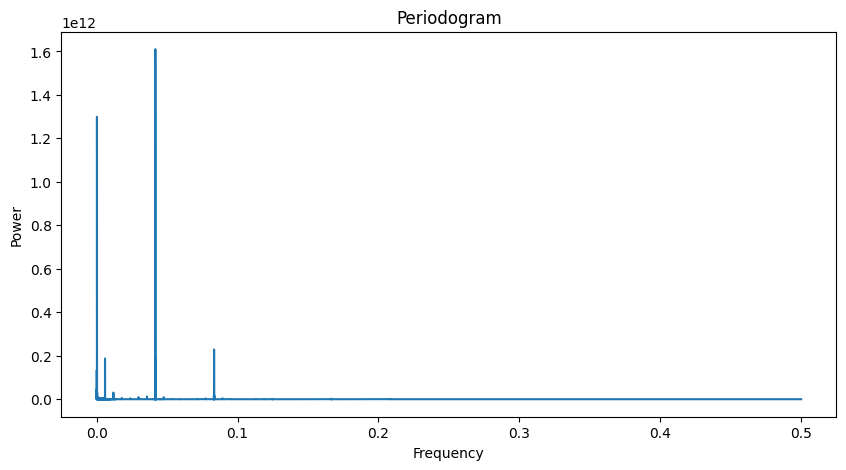

In [16]:
# Calculate the periodogram
frequencies, power = periodogram(water_data["Consumption"], fs=1)

plt.figure(figsize=(10,5))
plt.plot(frequencies, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Periodogram")
plt.show()

We can clearly see that there are some strong frequencies embeded in the series. Now lets convert them to periods to see what is actualy happening. We take the 5 most strong frequencies and convert them to periods, then we round them up:

In [17]:
top5_index = np.argsort(power)[-5:][::-1]
print(f"Top 5 periods: {(1/frequencies[top5_index]).round()}", f"Top 5 powers {power[top5_index]}", sep="\n")

Top 5 periods: [  24. 4382.   12.  168.   24.]
Top 5 powers [1.61001552e+12 1.29868918e+12 2.29150833e+11 1.87523906e+11
 1.87368996e+11]


After we round up the values of the periods, we get the following results: 
1. The most strong periodic component has period = 24 (Daily seasonality) 
2. The second strongest periodic component has period = 4382 (almost half year seasonality, half year has 4380 hours) 
3. The third strongest periodic component has period = 168 (Weekly seasonality, 1 week has 168 hours)
4. The fourth strongest periodic component has again period = 24 (possibly the 24 period has a compound periodicity)
5. The fifth strongest periodic component has period = 12 (half day seasonality)

# Forecasting

We will use neural prophet model as a forecasting tool. It is made in pytorch and implements machine learning algorithms to estimate the parameters (SGD or AdamW optimizers) during training. 

In [7]:
prophet_data = water_data.reset_index()
prophet_data = prophet_data.rename(columns = {"Datetime": "ds", "Consumption": "y"})
prophet_data

,ds,y
0,2002-01-01 01:00:00,30393
1,2002-01-01 02:00:00,29265
2,2002-01-01 03:00:00,28357
3,2002-01-01 04:00:00,27899
4,2002-01-01 05:00:00,28057
...,...,...
131462,2016-12-31 19:00:00,34478
131463,2016-12-31 20:00:00,33328
131464,2016-12-31 21:00:00,32197
131465,2016-12-31 22:00:00,30909


## Model 1: Trend, seasonality

We begin by splitting to train and test sets. We choose train period to be 2002-2014 and validation period 2015-2016. <br>
The first model we will try to fit is a Piecewise linear trend (10 changepoints on the 80% of train set) combined with daily, weekly and yearly seasonalities<br>
After we fit the model, we observe the last epoch metrics, the prediction on train and validation sets and the fitted components

In [8]:
# defaults:
# Piecewise linear trend. 10 changepoints on the 80% of train set
# Daily, weekly and yearly seasonality
m = NeuralProphet()

# split to train period = 2002-2014 (13 years) and test period = 2015-2016 (2 years)
df_train, df_test = m.split_df(prophet_data, freq="H", valid_p= (2*24*365 + 22)/len(prophet_data))


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [14]:
df_train

,ds,y
0,2002-01-01 01:00:00,30393
1,2002-01-01 02:00:00,29265
2,2002-01-01 03:00:00,28357
3,2002-01-01 04:00:00,27899
4,2002-01-01 05:00:00,28057
...,...,...
113920,2014-12-31 19:00:00,38906
113921,2014-12-31 20:00:00,37772
113922,2014-12-31 21:00:00,36602
113923,2014-12-31 22:00:00,35326


In [15]:
df_test

,ds,y
113925,2015-01-01 00:00:00,32802
113926,2015-01-01 01:00:00,31647
113927,2015-01-01 02:00:00,30755
113928,2015-01-01 03:00:00,30189
113929,2015-01-01 04:00:00,29890
...,...,...
131462,2016-12-31 19:00:00,34478
131463,2016-12-31 20:00:00,33328
131464,2016-12-31 21:00:00,32197
131465,2016-12-31 22:00:00,30909


In [146]:
# Fit model, save it and get epoch info
'''metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")
save(m, "first_model.np")'''

# load model and epoch info
m = load("first_model.np")
metrics = pd.read_csv("first_model_metrics.csv")

# Set plot backend
m.set_plotting_backend("matplotlib")

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


In [148]:
# Export metrics to csv and show last epoch data

#metrics.to_csv("first_model_metrics.csv", index=False)
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
29,3016.041016,3812.636719,0.029542,0.0,29,0.017605,0.0,2661.128418,3567.885986,0.017693,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.976% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.976% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


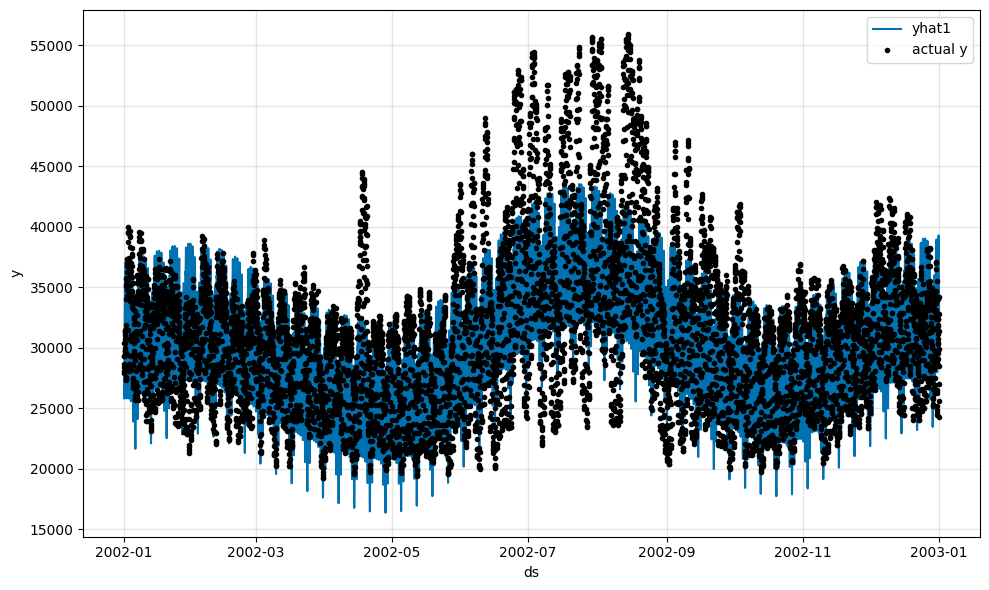

In [15]:
# Make the prediction and plot the first year of train set
forecast = m.predict(df_train)
m.plot(forecast[:24*365])

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


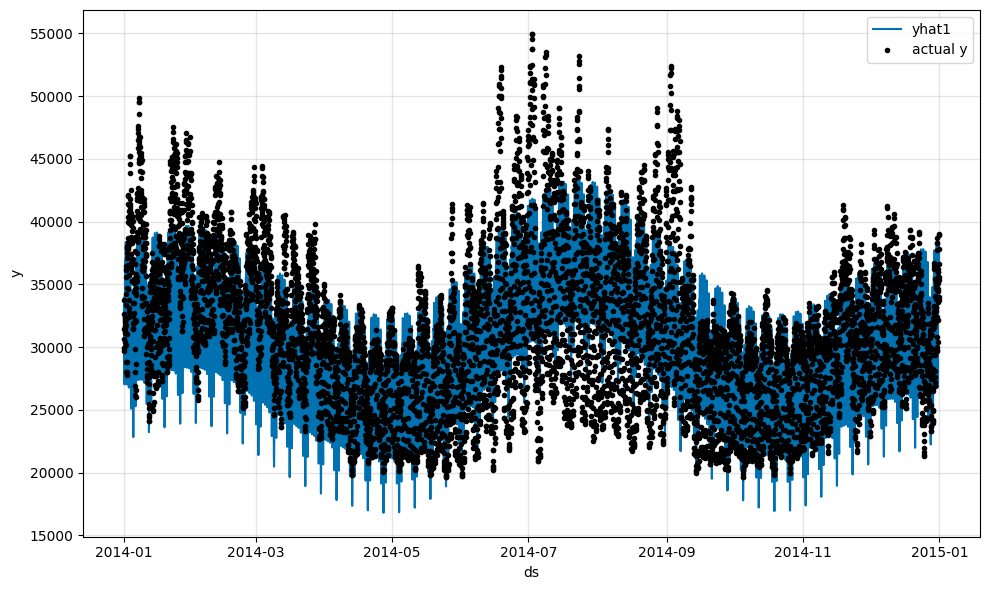

In [16]:
#plot the last year of train set
m.plot(forecast[-24*365:])

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


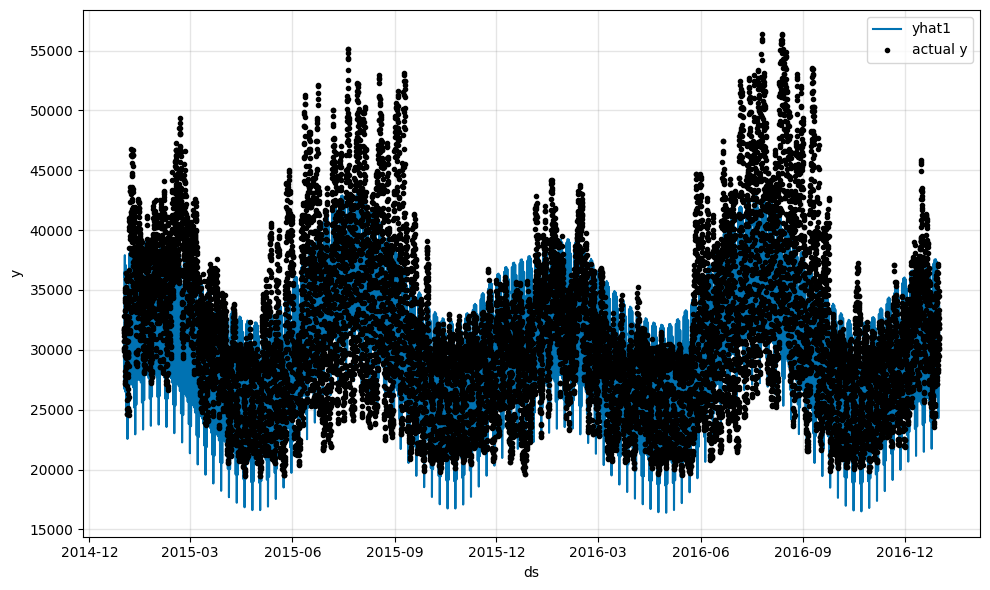

In [147]:
# Plot the prediction on validation set
val_forecast = m.predict(df_test)
m.plot(val_forecast)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


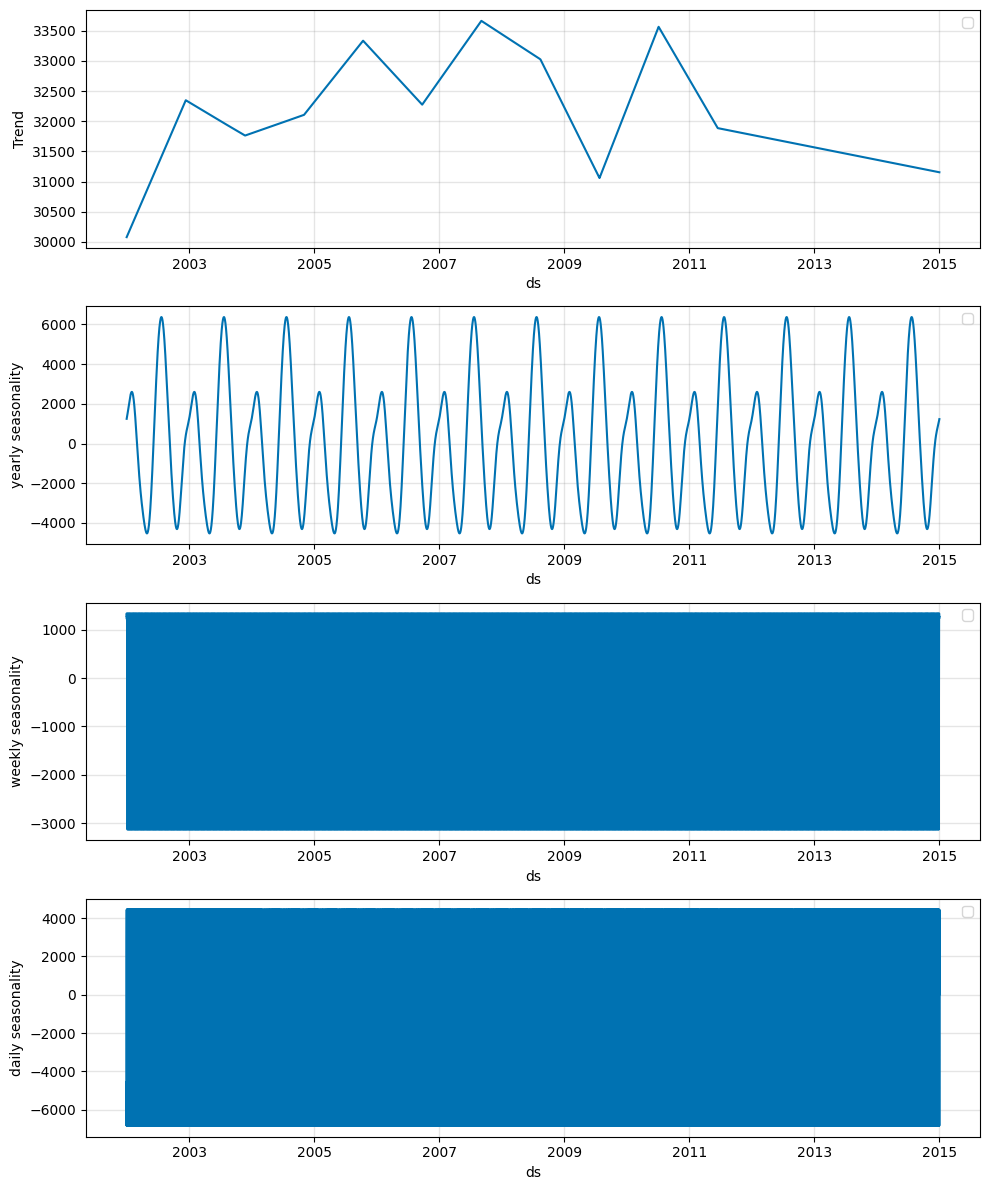

In [18]:
# Plot components fitted on train set
m.plot_components(forecast)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


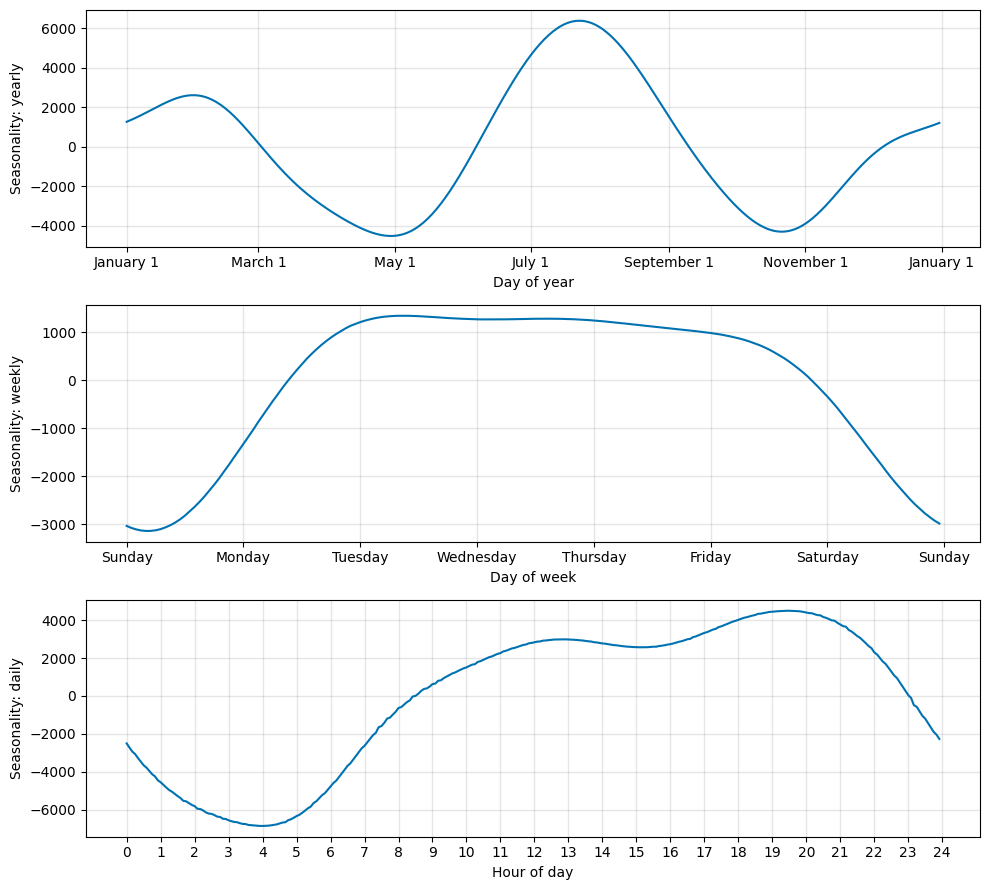

In [19]:
# Get a closer look at seasonalities
m.plot_parameters(components=["seasonality"])

## Model 2: Trend, seasonality, Auto Regression

Next, we will add an Autoregression component in the forecaster and see if we can achieve better results. To find an appropriate number of lags, we will make a Partial Autocorelation chart. This chart tells us how much each lag is influencing a given timeseries value. Documantation says its recommended to use more lags than the steps forecasted at one time. We want to forecast 2 years in the future, which implies approximately 24 * 365 * 2 steps which seem a lot. Therefore, we choose to forecast 1 week (24 * 7 steps) at a time and use at most 2 week (24 * 7 * 2) lags.

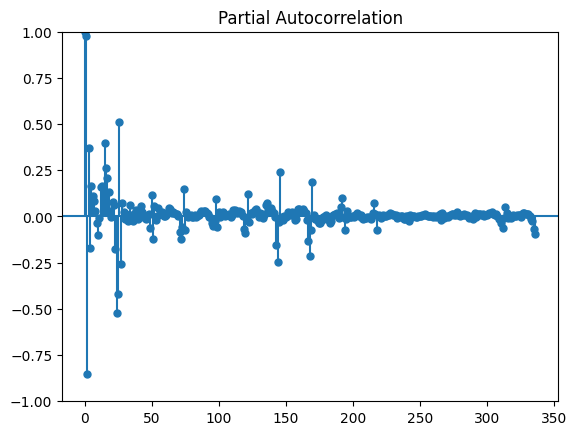

In [ ]:
# plot autocorelation chart for 2 weeks (24*7*2) lags
plot_pacf(water_data["Consumption"], lags = 24*7*2);

We want to include more than 1 week lags. So more than 7 * 24 = 168 lags. We can choose 175 lags based on the autocorrelation chart, as we observe that the correlation is not quite strong for further lags

In [ ]:
# Same as first model but we add AR order = 175
# forecast steps = 1 week = 7*24 steps = 168 steps
m2 = NeuralProphet(n_lags=175, n_forecasts=168)

In [8]:
'''metrics2 = m2.fit(df_train, freq="H", validation_df=df_test, progress="bar")
save(m2, "second_model.np")'''

metrics2 = pd.read_csv("second_model_metrics.csv")
m2 = load("second_model.np")

m2.set_plotting_backend("matplotlib")

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


In [10]:
#metrics2.to_csv("second_model_metrics.csv", index=False)
metrics2.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
29,2269.612793,3024.18335,0.01843,0.0,29,0.011444,0.0,2058.872559,2860.997559,0.011444,0.0


It seems that the Autoregression component can model the timeseries lag dependencies and give better forecasting performance. Lets make some plots to observe the results.
Our model has at most 168 prediction values for each timeseries point due to multistep forecasting. We are going to filter the multiple forecast values and predict the next 168 values after every end of the previous 168 value forecast.

In [107]:
# Aggregate forecasts function
def agg_forecasts(model, fcst):

    agg_fcst = fcst[["ds","y"]]
    agg_fcst["Agg predictions"] = None
    agg_fcst["prediction no."] = None
    agg_fcst["Ar component"] = None
    
    fcst_values = fcst.iloc[:, 2:2+model.n_forecasts].to_numpy()
    ar_values = fcst.iloc[:, 2+model.n_forecasts:2+model.n_forecasts*2].to_numpy()
    
    # Add each 168 length forecast to agg_fcst
    count = 1
    for i in range(model.n_lags, fcst_values.shape[0], model.n_forecasts):
        if i + model.n_forecasts > fcst_values.shape[0]-1:
            break
        agg_fcst["Agg predictions"][i:i+model.n_forecasts] = fcst_values[i:i+model.n_forecasts, :][np.eye(model.n_forecasts, dtype=bool)]
        agg_fcst["Ar component"][i:i+model.n_forecasts] = ar_values[i:i+model.n_forecasts, :][np.eye(model.n_forecasts, dtype=bool)]
        agg_fcst["prediction no."][i:i+model.n_forecasts] = count
        count+=1

    return agg_fcst

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Added 2 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 2 NaN values in column y were auto-imputed.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


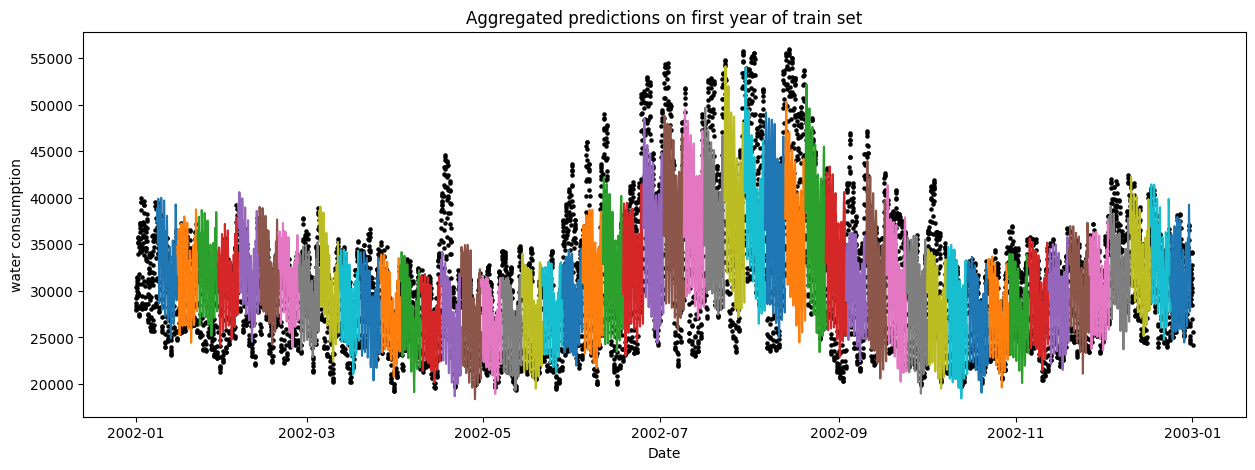

In [109]:
# Make the forecast for the first year in train set
forecast2 = m2.predict(df_train[:24*365])

# Aggregate forecast values and plot the forecast
agg_forecast2 = agg_forecasts(m2, forecast2)

plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("water consumption")
plt.title("Aggregated predictions on first year of train set")
for i in agg_forecast2["prediction no."].unique()[1:]:
    current_forecast = agg_forecast2[agg_forecast2["prediction no."] == i]
    plt.plot(current_forecast["ds"], current_forecast["Agg predictions"])

plt.scatter(agg_forecast2["ds"], agg_forecast2["y"], c = "black", s = 5)


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Added 2 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 2 NaN values in column y were auto-imputed.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


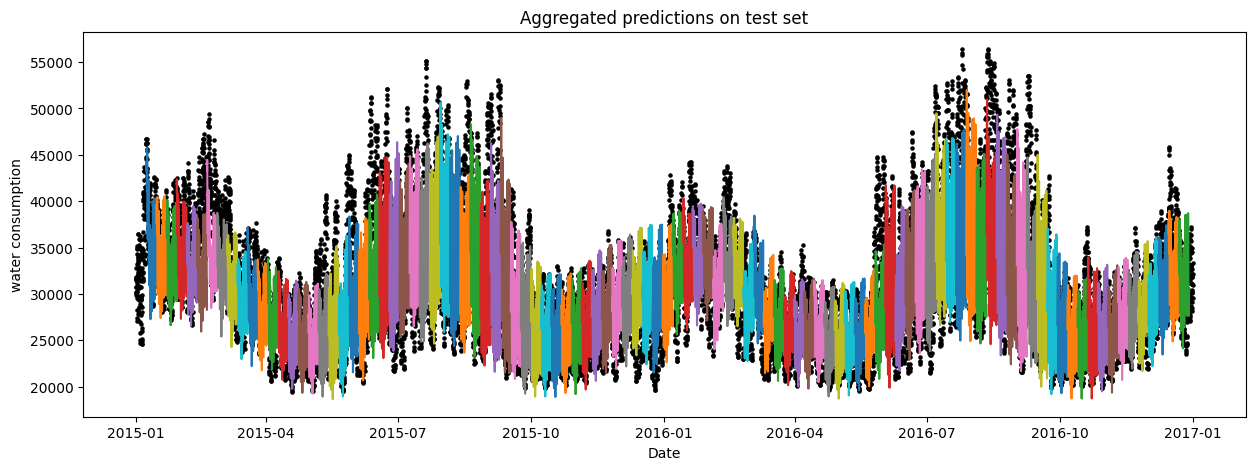

In [106]:
# Make the forecast for the test set
forecast_val2 = m2.predict(df_test)

# Aggregate forecast values and plot the forecast
agg_forecast_val2 = agg_forecasts(m2, forecast_val2)

plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("water consumption")
plt.title("Aggregated predictions on test set")
for i in agg_forecast_val2["prediction no."].unique()[1:]:
    current_forecast = agg_forecast_val2[agg_forecast_val2["prediction no."] == i]
    plt.plot(current_forecast["ds"], current_forecast["Agg predictions"])

plt.scatter(agg_forecast_val2["ds"], agg_forecast_val2["y"], c = "black", s = 5)

Text(0.5, 1.0, 'Ar component prediction on first year of train set')

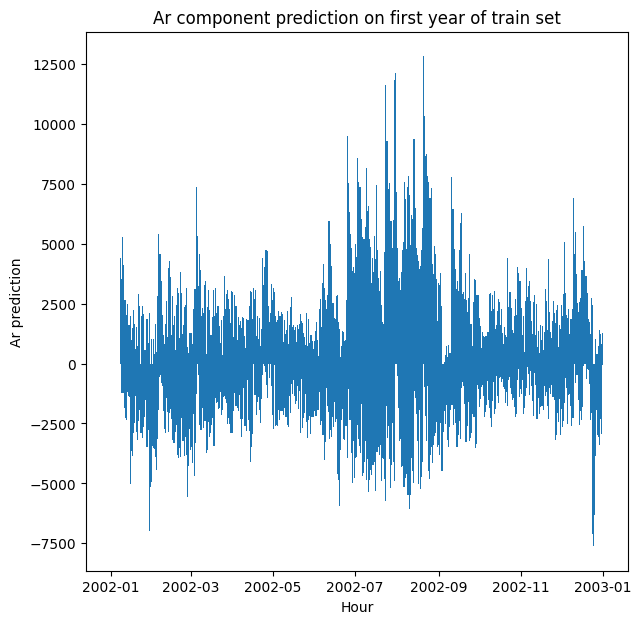

In [125]:
# Plot Ar component individual prediction on first year of train set
# The rest components are the same as model1

ar_comp = agg_forecast2
ar_comp["Ar component"] = ar_comp["Ar component"].fillna(0)
plt.figure(figsize=(7,7))
plt.bar(ar_comp["ds"], ar_comp["Ar component"])
plt.xlabel("Hour")
plt.ylabel("Ar prediction")
plt.title("Ar component prediction on first year of train set")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


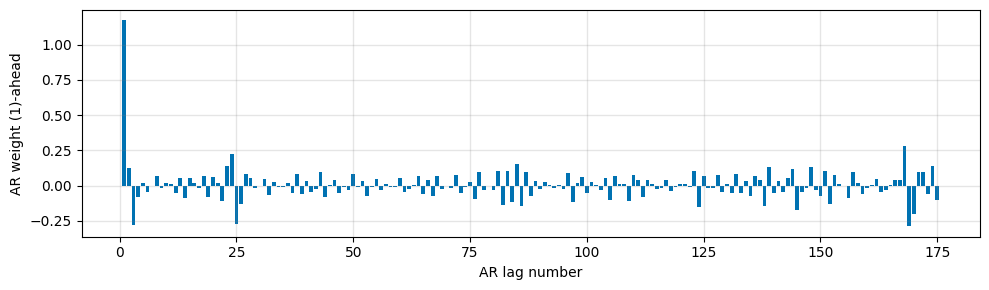

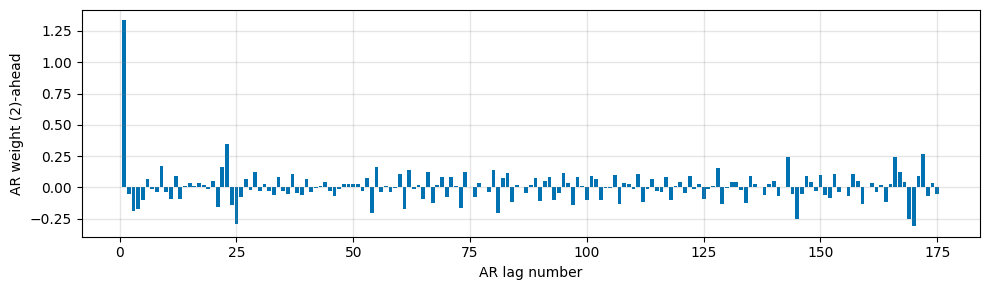

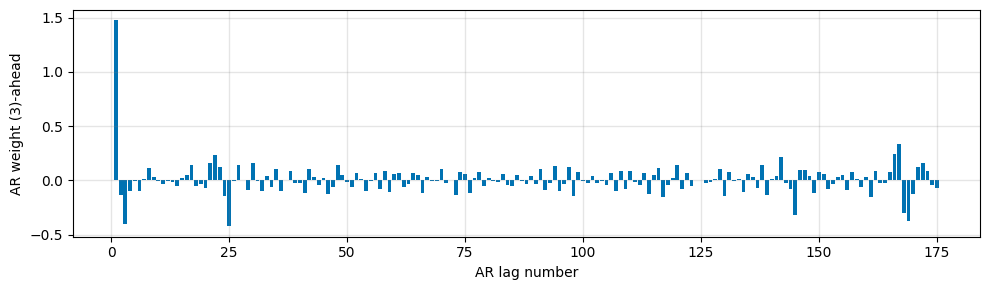

In [136]:
# Plot fitted AR weights for 1, 2 and 3 step ahead predictions
m2.plot_parameters(components=["autoregression"], forecast_in_focus=1)
m2.plot_parameters(components=["autoregression"], forecast_in_focus=2)
m2.plot_parameters(components=["autoregression"], forecast_in_focus=3)

## Model 3: Trend, seasonality, AR-Net

Last, we will modify the AR component to deep neural network architecture. 
Lets see if a more complicated relationship between lags and timeseries values can achieve better performance

In [127]:
# Same as previous model but with 2 hidden layers added.
# Documentation suggests: n_forecasts <= hidden layer dimension <= n_lags
m3 = NeuralProphet(n_lags=175, n_forecasts=168, ar_layers=[168, 168])

In [141]:
'''metrics3 = m3.fit(df_train, freq="H", validation_df=df_test, progress="bar")
save(m3, "third_model.np")'''

metrics3 = pd.read_csv("third_model_metrics.csv")
m3 = load("third_model.np")

m3.set_plotting_backend("matplotlib")

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


In [142]:
#metrics3.to_csv("third_model_metrics.csv", index=False)
metrics3.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
29,3077.723389,3920.338623,0.030073,0.0,29,0.017853,0.0,2673.622803,3593.342529,0.017854,0.0


It seems that the metrics went worse. Maybe the DNN architecture in AR component adds unnecessary complexity

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.966% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Added 2 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 2 NaN values in column y were auto-imputed.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


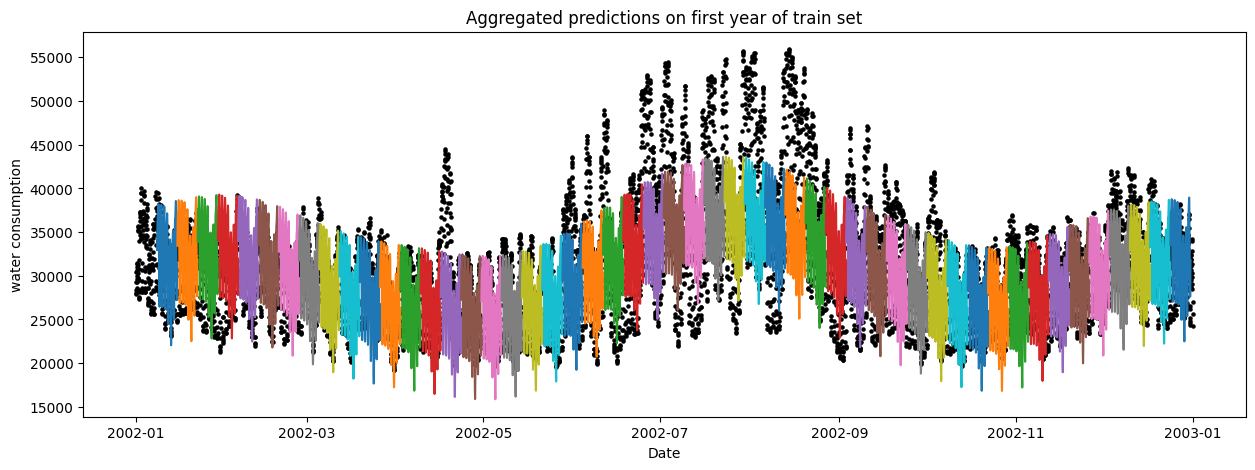

In [133]:
# Make the forecast for the first year in train set
forecast3 = m3.predict(df_train[:24*365])

# Aggregate forecast values and plot the forecast
agg_forecast3 = agg_forecasts(m3, forecast3)

plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("water consumption")
plt.title("Aggregated predictions on first year of train set")
for i in agg_forecast3["prediction no."].unique()[1:]:
    current_forecast = agg_forecast3[agg_forecast3["prediction no."] == i]
    plt.plot(current_forecast["ds"], current_forecast["Agg predictions"])

plt.scatter(agg_forecast3["ds"], agg_forecast3["y"], c = "black", s = 5)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Added 2 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 2 NaN values in column y were auto-imputed.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


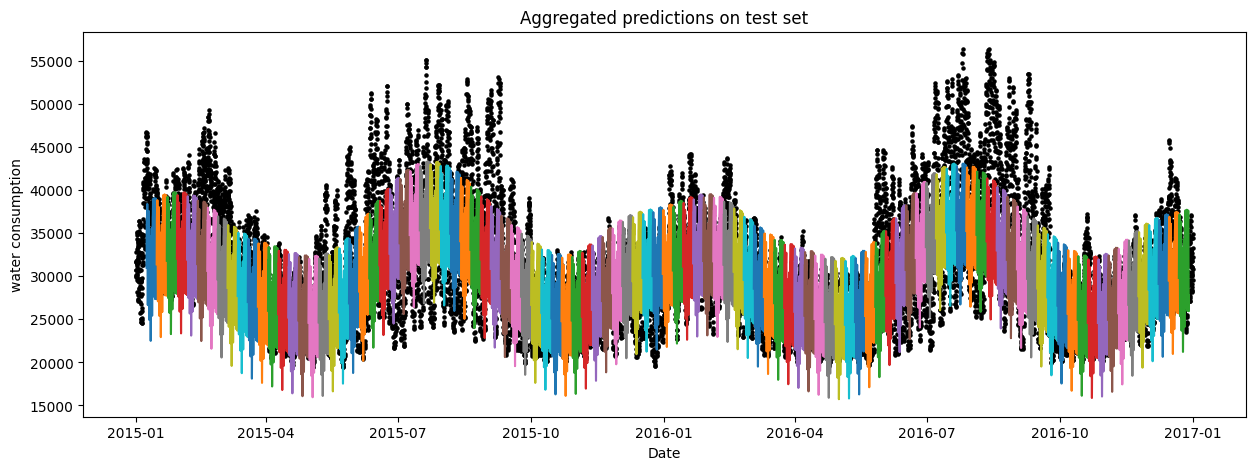

In [131]:
# Make the forecast for the test set
forecast_val3 = m3.predict(df_test)

# Aggregate forecast values and plot the forecast
agg_forecast_val3 = agg_forecasts(m3, forecast_val3)

plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("water consumption")
plt.title("Aggregated predictions on test set")
for i in agg_forecast_val3["prediction no."].unique()[1:]:
    current_forecast = agg_forecast_val3[agg_forecast_val3["prediction no."] == i]
    plt.plot(current_forecast["ds"], current_forecast["Agg predictions"])

plt.scatter(agg_forecast_val3["ds"], agg_forecast_val3["y"], c = "black", s = 5)

Text(0.5, 1.0, 'Ar component prediction on first year of train set')

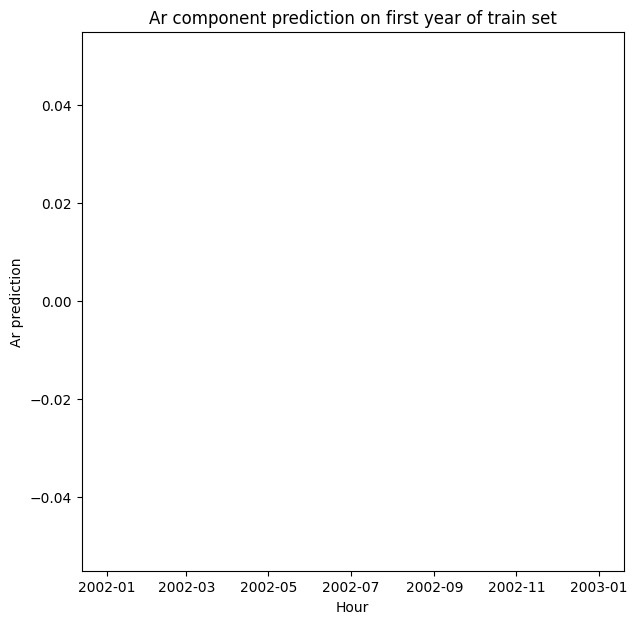

In [132]:
# Plot Ar component individual prediction on first year of train set
# The rest components are the same as model1

ar_comp = agg_forecast3
ar_comp["Ar component"] = ar_comp["Ar component"].fillna(0)
plt.figure(figsize=(7,7))
plt.bar(ar_comp["ds"], ar_comp["Ar component"])
plt.xlabel("Hour")
plt.ylabel("Ar prediction")
plt.title("Ar component prediction on first year of train set")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


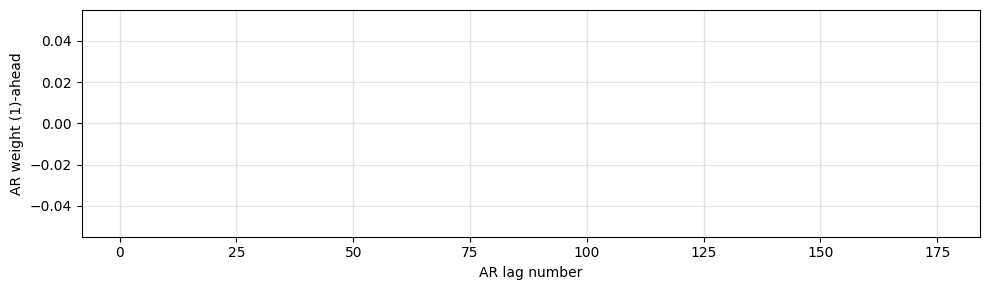

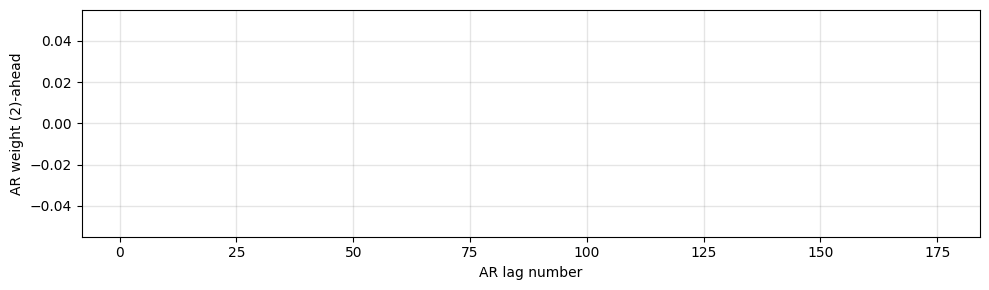

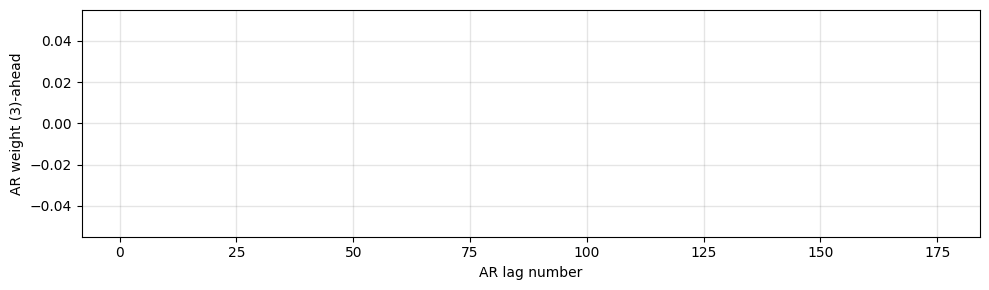

In [144]:
m3.plot_parameters(components=["autoregression"], forecast_in_focus=1)
m3.plot_parameters(components=["autoregression"], forecast_in_focus=2)
m3.plot_parameters(components=["autoregression"], forecast_in_focus=3)

It seems like the model failed to fit any AR weights this time. That means complex relationship between timeseries and lags is not helping the model to learn

# Performance metrics, Validation-Training Plots, Future prediction and Conclusions

We present a pandas table which includes the MAPE, MAE and RMSE achieved in the validation set after 30 epochs of training, for each model.<br> We skip the third model because it is basicaly the same as model 1 due to zero AR weights

In [149]:
# Get mape from each forecast (rounded to 2 decimals)
mape1 = ((abs(val_forecast["y"] - val_forecast["yhat1"])/val_forecast["y"]).mean()*100).round(2)
mape2 = ((abs(agg_forecast_val2["y"] - agg_forecast_val2["Agg predictions"])/agg_forecast_val2["y"]).mean()*100).round(2)

# Get mae for our custom aggregate forecast
mae2 = abs(agg_forecast_val2["y"] - agg_forecast_val2["Agg predictions"]).mean().round(2)

# Get RMSE for our custom aggregate forecast
rmse2 = np.sqrt(((agg_forecast_val2["y"] - agg_forecast_val2["Agg predictions"])**2).mean()).round(2)

performance_metrics = pd.DataFrame(index=["model1", "model2"], 
                                   data = {"MAPE_val (%)": [mape1, mape2], 
                                           "MAE_val": [metrics["MAE_val"].iloc[-1].round(2), mae2], 
                                           "RMSE_val": [metrics["RMSE_val"].iloc[-1].round(2), rmse2],
                                           "model desc." : ["piecewise trend, D,W,Y seasonality", "model1 + AR(175) and fcst step = 168"]})
performance_metrics

,MAPE_val (%),MAE_val,RMSE_val,model desc.
model1,9.34,3016.04,3812.64,"piecewise trend, D,W,Y seasonality"
model2,6.94,2286.99,3185.17,model1 + AR(175) and fcst step = 168


It seems like **model2** has the best performance. Lets plot its Train-Validation loss progress:

Text(0.5, 1.0, 'Model 2 performance')

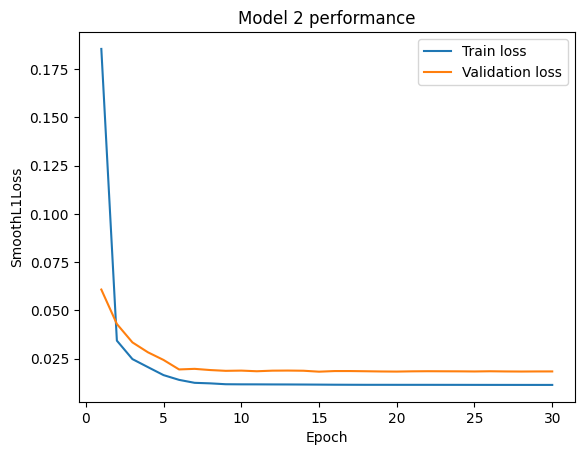

In [150]:
plt.plot(metrics2["epoch"] + 1, metrics2["Loss"])
plt.xlabel("Epoch")
plt.ylabel("SmoothL1Loss")

plt.plot(metrics2["epoch"] + 1, metrics2["Loss_val"])
plt.xlabel("Epoch")
plt.ylabel("SmoothL1Loss")

plt.legend(["Train loss", "Validation loss"])
plt.title("Model 2 performance")

We will now use model2 to make predictions for the future. The predictions take place from the beginning of 2017 until the end of 2018. We predict 1 week ie 168 steps each time. For the next prediction, we use the previous predicted values as input.

In [107]:
# Get just the appropriate amount of lags to forecast forward one time
future_df = m2.make_future_dataframe(prophet_data, n_historic_predictions=False)
future_df

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y
0,2016-12-24 17:00:00,30841
1,2016-12-24 18:00:00,32422
2,2016-12-24 19:00:00,31787
3,2016-12-24 20:00:00,31040
4,2016-12-24 21:00:00,30532
...,...,...
338,2017-01-07 19:00:00,None
339,2017-01-07 20:00:00,None
340,2017-01-07 21:00:00,None
341,2017-01-07 22:00:00,None


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.708% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.708% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 168 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


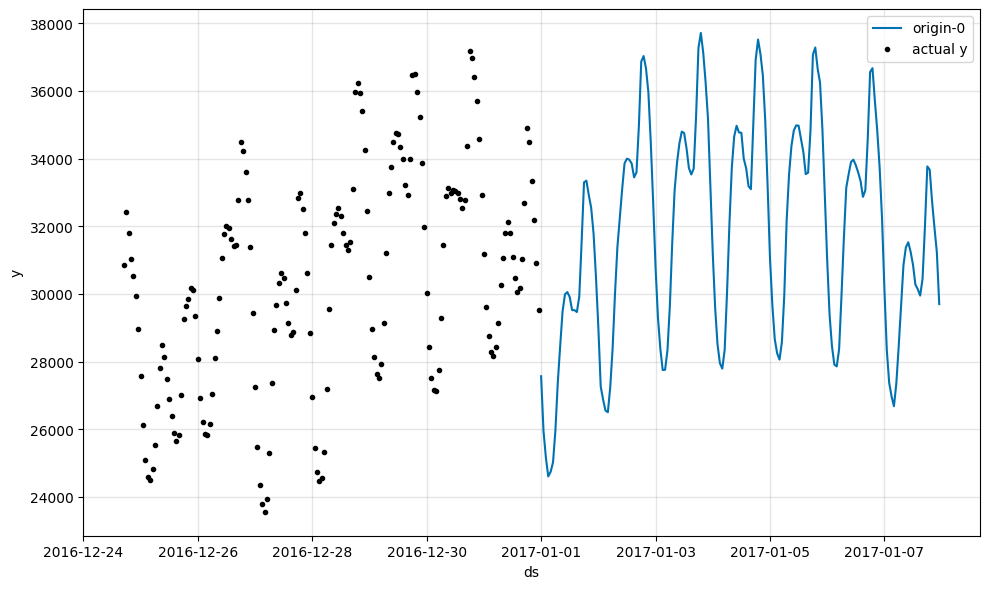

In [108]:
# Predict one week into the future
future_prediction = m2.predict(future_df)
m2.plot(future_prediction)

In [ ]:
# Iteratively predict next week based on the previous forecast values. 
# Stop before predictions reach 2019
# Use only the required history to make 1 prediction
fcst_step = m2.n_forecasts
future_df["y"][-fcst_step:] = future_prediction.to_numpy()[-fcst_step:, 2:2+fcst_step][np.eye(fcst_step, dtype=bool)]

while True:
    temp_df = m2.make_future_dataframe(future_df, n_historic_predictions=False)
    if (pd.DatetimeIndex(temp_df["ds"]).year == 2019).any():
        break
    future_df = m2.make_future_dataframe(future_df, n_historic_predictions=True)
    future_prediction = m2.predict(temp_df)
    future_df["y"][-fcst_step:] = future_prediction.to_numpy()[-fcst_step:, 2:2+fcst_step][np.eye(fcst_step, dtype=bool)]

In [110]:
future_df

,ds,y
0,2016-12-24 17:00:00,30841.0
1,2016-12-24 18:00:00,32422.0
2,2016-12-24 19:00:00,31787.0
3,2016-12-24 20:00:00,31040.0
4,2016-12-24 21:00:00,30532.0
...,...,...
17642,2018-12-29 19:00:00,32892.851562
17643,2018-12-29 20:00:00,32642.234375
17644,2018-12-29 21:00:00,32123.496094
17645,2018-12-29 22:00:00,30929.222656


In [111]:
# Make final modifications in df in order to predict with model.plot
future_df["yhat1"] = future_df["y"]
future_df.loc[m2.n_lags: , "y"] = None
future_df.loc[:m2.n_lags-1 , "yhat1"] = None

future_df

,ds,y,yhat1
0,2016-12-24 17:00:00,30841.0,None
1,2016-12-24 18:00:00,32422.0,None
2,2016-12-24 19:00:00,31787.0,None
3,2016-12-24 20:00:00,31040.0,None
4,2016-12-24 21:00:00,30532.0,None
...,...,...,...
17642,2018-12-29 19:00:00,None,32892.851562
17643,2018-12-29 20:00:00,None,32642.234375
17644,2018-12-29 21:00:00,None,32123.496094
17645,2018-12-29 22:00:00,None,30929.222656


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


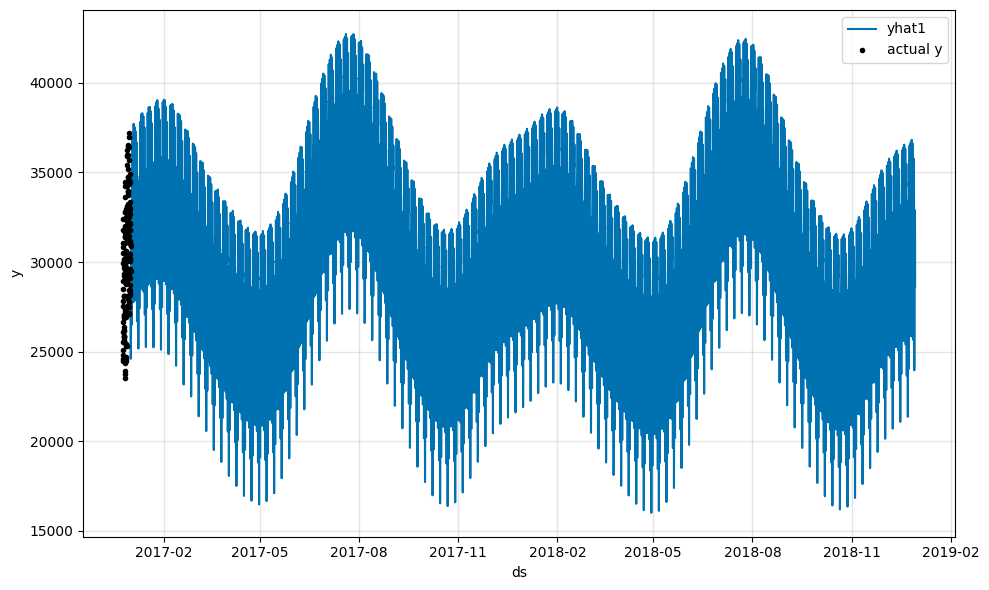

In [112]:
# Plot 2 year prediction
m2.plot(future_df)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


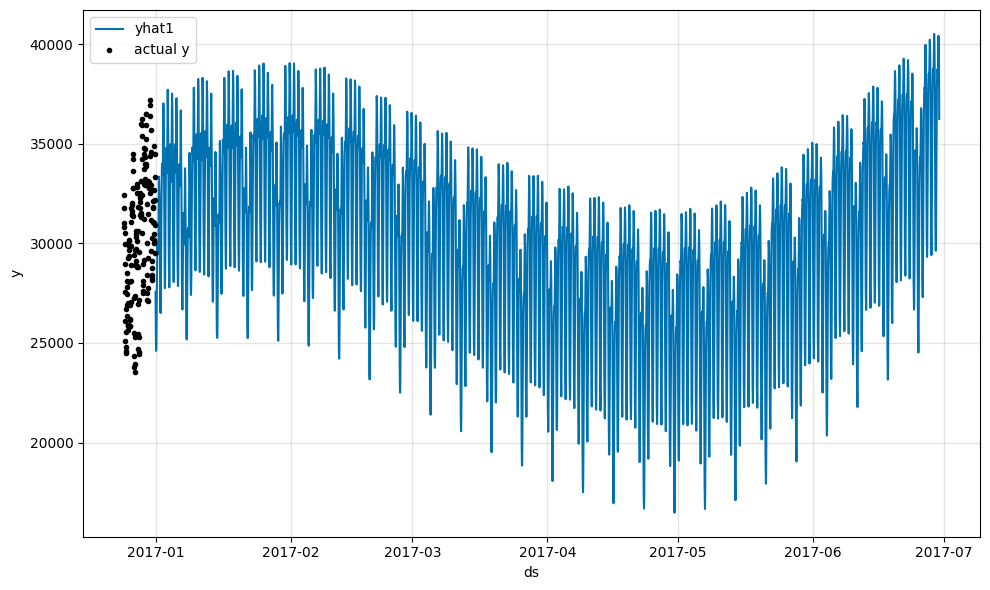

In [ ]:
# Observe better the first 6 months
m2.plot(future_df[:m2.n_lags+24*30*6])

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


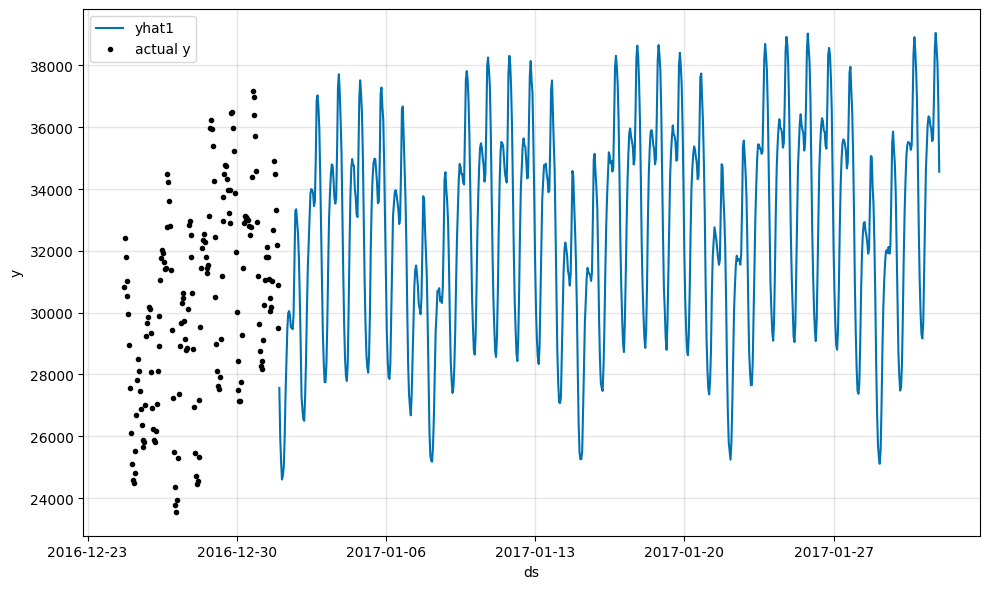

In [121]:
# Observe better the first month
m2.plot(future_df[:m2.n_lags+24*31])

## Conclusion 

Our beginning plot and analysis of the timeseries showed that water consumption does not show (statistical) evidence of strong trend during the past years. Seasonality components were somewhat clear by the eye, especialy a yearly one. Nevertheless, after analyzing the periodogram it turned out that daily, 6-month and weekly seasonalities were most present. Even though the trend shows statistical insignificance, Neural Prophet could fit a piecewise linear trend along with seasonalities to achieve performable forecasts. AR then came to play, in order to model the relationship between timeseries and its past values, by concluding that a complicated relationship between them with DNN does not fit. Autocorrelation chart helped to determine the simple AR lag order.

Piecewise linear trend, seasonalities and AutoRegression components seem to constitute a reliable model with metrics:<br>
<br>
**MAPE: 6.94%**<br><br>
**MAE:  2286.99**<br><br>
**RMSE: 3185.17**